In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import gym
import numpy as np
import random
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import files
from collections import deque
import os
from gym.wrappers import Monitor
from gym import logger as gymlogger
import glob
import io
import base64

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
class Deepqnet:
    def __init__(self, sta_size, act_size):
        self.df=0.99    
        self.eps_decay=0.98
        self.eps_min=0.01
        self.act_size=act_size
        self.val=0
        self.sta_size=sta_size
        self.mem=deque(maxlen=2000)
        self.model_t=self.neural_net()
        self.model=self.neural_net()
        self.eps=1.0 
        self.update_fn()

    #def loadm(self)
    #Select action(epsilon greedy)
    def act(self, state):
        if(np.random.uniform(0, 1)<=self.eps):
            return random.randrange(self.act_size)
        else:
          act_values=self.model.predict(state)
          return np.argmax(act_values[0]) 

    #Update weights
    def update_fn(self):
        self.model_t.set_weights(self.model.get_weights())

    def neural_net(self):
        model = Sequential()
        #Core model for training
        model.add(Dense(64, input_dim=4,activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.act_size, activation='linear'))
        model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.001))
        return(model)

    #Save Model
    def model_s(self, name):
        self.model.save(name)

    #To store the transactions
    def rem(self, state, act, rew, nxt_sta, done):
        self.mem.append((state, act, rew, nxt_sta, done))

    #To execute
    def execute(self, b_size):
        m_bat=random.sample(self.mem, b_size)
        for sta, act, rew, nxt_sta, done in m_bat:
            tgt=self.model.predict(sta)
            if(not done):
                fut_q =self.model_t.predict(nxt_sta)[0]
                tgt[0][act]=rew+(self.df*np.amax(fut_q))
            else:
                tgt[0][act]=rew
            h=self.model.fit(sta, tgt, epochs=1, verbose=0)
        loss=h.history['loss'][0]
        return loss

2
4












Episode: 0/1001, Reward: 54.0, Loss: 0.00041932667954824865, Epsilon: 1.0
saving the model
Episode: 1/1001, Reward: 11.0, Loss: 0.02485499531030655, Epsilon: 0.98
Episode: 2/1001, Reward: 28.0, Loss: 4.457429167814553e-05, Epsilon: 0.96
Episode: 3/1001, Reward: 21.0, Loss: 0.0029584558214992285, Epsilon: 0.94
Episode: 4/1001, Reward: 10.0, Loss: 1.0398640632629395, Epsilon: 0.92
Episode: 5/1001, Reward: 10.0, Loss: 0.05786897614598274, Epsilon: 0.9
Episode: 6/1001, Reward: 11.0, Loss: 0.21244068443775177, Epsilon: 0.89
Episode: 7/1001, Reward: 10.0, Loss: 0.249888613820076, Epsilon: 0.87
Episode: 8/1001, Reward: 15.0, Loss: 0.030038179829716682, Epsilon: 0.85
Episode: 9/1001, Reward: 29.0, Loss: 0.2560778558254242, Epsilon: 0.83
Episode: 10/1001, Reward: 29.0, Loss: 0.10029730200767517, Epsilon: 0.82
Episode: 11/1001, Reward: 17.0, Loss: 0.0676930621266365, Epsilon: 0.8
Episode: 12/1001, Reward: 18.0, Loss: 0.2530829906463623, Epsilon: 0.78
Episode: 13/1001, Reward: 33.

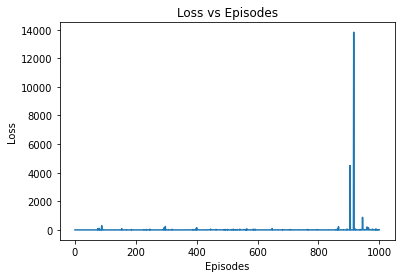

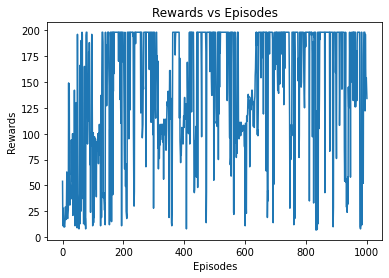

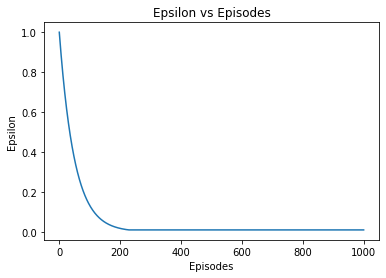

In [0]:
if __name__ == "__main__":
    batch_size = 32
    env = gym.make('CartPole-v0')
    action_size = env.action_space.n
    print(action_size)
    state_size = env.observation_space.shape[0]
    print(state_size)
    agent = Deepqnet(state_size, action_size)
    loss_val=[]
    scores = []
    eps_val=[]
    epis=1001
    done = False
    loss=0

    for i in range(epis):
        done=False
        state = env.reset()
        state = np.reshape(state,[1, state_size])
        total_reward = 0
        while(not done):
            action = agent.act(state)
            sta_nxt, reward, done, info = env.step(action)
            sta_nxt = np.reshape(sta_nxt, [1, state_size])
            reward = reward if not done else -1
            agent.rem(state, action, reward, sta_nxt, done)
            total_reward += reward
            state = sta_nxt
            if done:
                scores.append(total_reward)
                agent.update_fn()
                eps_val.append(agent.eps)
                loss_val.append(loss)        
                print("Episode: {}/{}, Reward: {}, Loss: {}, Epsilon: {:.2}".format(i, epis, total_reward, loss, agent.eps))
                if(agent.eps>agent.eps_min):
                    agent.eps*=agent.eps_decay
                break
            
            if len(agent.mem) > batch_size:
                loss=agent.execute(batch_size)

        if(i % 100 == 0):
            print('saving the model')
            model_name = "cartpole_dqn_final_20.h5"
            plot_name = "score_plot"
            model_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/", model_name)
            plot_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/", plot_name)
            agent.model_s(model_path)
            # saving the figure
            #print(scores)
            #plt.savefig('score_plot.jpg')
            #files.download('score_plot.jpg')
            #print(loss_val)
            #plt.savefig('loss.jpg')
            #files.download('loss.jpg')

    plt.figure(1)             
    plt.plot(loss_val)
    plt.title('Loss vs Episodes')
    plt.ylabel('Loss')
    plt.xlabel('Episodes')
    
    plt.figure(2)             
    plt.plot(scores)
    plt.title('Rewards vs Episodes')
    plt.ylabel('Rewards')
    plt.xlabel('Episodes')
    
    plt.figure(3)             
    plt.plot(eps_val)
    plt.title('Epsilon vs Episodes')
    plt.ylabel('Epsilon')
    plt.xlabel('Episodes')